In [2]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [ ]:
# The following classes can be heavily parallelized. Currently samples are collected over loops.

In [69]:
# Define the mixture model

class Mixture:
    # takes in an np array of parameters
    def __init__(self, fns, stds, weights):
        assert(np.sum(weights)==1.)
        self.num_components = len(fns)
        self.stds = stds 
        self.weights = weights
        self.fns = fns
    
    def sample(self, X, n):        
        y = []
        
        mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
        for i in range(n):
            mixture_id = mixture_idx[i]
            means = self.fns[mixture_id](X)
            std = self.stds[mixture_id]
            y_ = [ss.norm.rvs(m, std) for m in means]
            y.append(y_)
        return np.array(y).transpose()
    
    def prod(self, X, Y):
        all_pdfs = []
        
        for x, y in zip(X, Y):
            p = []
            means = [f(x) for f in self.fns]
            
            for m, s, w in zip(means, self.stds, self.weights):
                p.append(ss.norm.pdf(y, loc=m, scale=s))
                
            all_pdfs.append(p)
        all_pdfs = np.squeeze(np.array(all_pdfs))        
        prod = np.prod(all_pdfs, axis=0)*self.weights
        
        return prod
        
        
    def pdf(self, X, Y):
        return np.sum(self.prod(X, Y))
    
    def condition(self, X, Y):
        pdf = self.pdf(X, Y)
        prod = self.prod(X, Y)
        self.weights = prod/pdf


In [92]:
# Define the moment matched prediction map for a mixture model

class MomentPredictionMap:
    # takes in an np array of parameters
    def __init__(self, mixture):
        self.mixture = mixture
        self.mean = self.get_mean(mixture)
        self.std = self.get_std(mixture)
        
    @staticmethod
    def get_mean(mixture):
        def mean(x):
            m = 0.
            for w, f in zip(mixture.weights, mixture.fns):
                m += w*f(x)
            return m
        return mean
    
    @staticmethod
    def get_std(mixture):
        def std(x):
            weighted_var = 0.
            weighted_mean = 0.
            weighted_mean_sqr = 0.
            for w, std, f in zip(mixture.weights, mixture.stds, mixture.fns):
                weighted_var += w * std**2
                weighted_mean += w * f(x)
                weighted_mean_sqr += w * f(x)**2
            return np.sqrt(weighted_var + weighted_mean_sqr - weighted_mean**2)
        return std
    

    def pdf(self, X, Y):
        p = []
        
        for x, y in zip(X, Y):    
            p.append(ss.norm.pdf(y, loc=self.mean(x), scale=self.std(x)))
                
        p = np.squeeze(np.array(p))        
        prod = np.prod(p, axis=0)
        
        return prod
    
    def sample(self, X, n):
        y = []
        for i in range(n):
            y_ = [ss.norm.rvs(self.mean(x), self.std(x)) for x in X]
            y.append(y_)
        return np.array(y).transpose()
        

In [93]:
# defining the parameters for and initializing a mixture model

def f1(x):
    return x**2
def f2(x):
    return x
def f3(x):
    return -x

fns = [f1, f2, f3]
stds = [1., 0.5, 1.]
weights = [0.25, 0.5, 0.25]


m = Mixture(fns, stds, weights)

In [105]:
# Computing the density of the mixture model at a collection of points

X = np.array([1., 2.]) 
Y = np.array([0.1, 0.3])

m.pdf(X,Y)

0.0017656014481578323

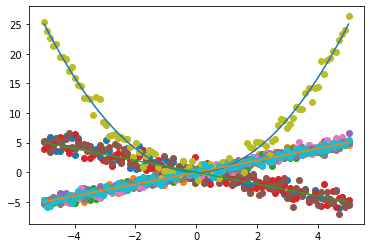

In [104]:
# Sampling from the mixture model

n_samples = 10
X = np.linspace(-5,5,100)
Y = np.array(m.sample(X, n_samples)) 

plt.plot(X, f1(X))
plt.plot(X, f2(X))
plt.plot(X, f3(X))

for i in range(n_samples):
    plt.scatter(X, Y[:, i])

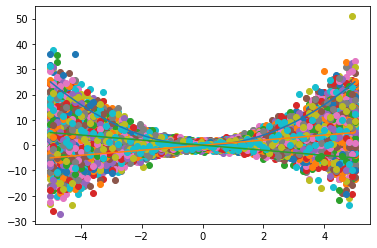

In [102]:
# Let's sample from the moment matched prediction map for this mixture model

mom_pred = MomentPredictionMap(m)

n_samples = 100
Y_ = mom_pred.sample(X, n_samples)
plt.plot(X, f1(X))
plt.plot(X, f2(X))
plt.plot(X, f3(X))

for i in range(n_samples):
    plt.scatter(X, Y_[:, i])